# Sparsity
In this notebook we will take a look at sparse signals and note some of their properties. We will follow the following notational conventions. We will define a signal, $\mathbf{x} \in \mathbb{R}^N$ to be *sparse* if $K$ elements of $\mathbf{x}$ are non-zero, while the remaining elements are exactly zero. We will define the *sparsity* of $\mathbf{x}$ to be the ratio of the number of non-zeros to zeros,
$$\rho = \frac{K}{N}.$$

Below, we will take a look at a few such signals and study their properties.

In [1]:
# Including Dependencies
%matplotlib inline         
import scipy
import numpy as np                  # Numpy, très important
import matplotlib.pyplot as plt     # PyPlot for Plotting
import scipy.fftpack as fftpk       # FFTPack for Harmonic Analy.
import scipy.linalg as la           # For Linear Algebra
import pywt as pw                   # PyWavelets
import scipy.signal as sig          # For signal processing, like conv
from DepsSparsity import *

## Generating Random K-Sparse Signals
---

For now, let us confine ourselves to synthetic examples of exactly $K$-Sparse signals. Let us take a look at how to generate such a signal.

In [ ]:
def RandomKSparseSignal(K,N):
    """ Random realization of a K-sparse signal.
    
        Assumes that all non-zero components of the realization
        are drawn iid from a zero-mean Gaussian with a variance 
        of ``1``. 
    
        Input
        ---
        K: int
           Number of non-zeros in the signal.
        N: int
           Signal dimensionality (length)
        
        Returns
        ---
        x: array_like, float
           The K-sparse signal realization, shaped ``(n,1)``
        s: array_like, bool
           The support of ``x``, shaped ``(n,1)``. Has value
           ``True`` at every non-zero location of ``x`` and
           ``False`` everywhere else.
           
        
    """
    x = np.random.randn(N,1)                # Generate iid Gaussian samples     
    s = np.zeros((N,1),dtype=bool)          # Cast ``0.0`` as ``False``
    si = np.random.permutation(N)[1:K]      # Random support locations
    s[si] = True                            # Flag on-support values
    x[np.invert(s)] = 0.0                   # Suppress off-support values of ``x``
    
    return x, s

Now, lets take a look at what what one of these $K$-sparse signals looks like.

In [ ]:
N = 1024         # Desired signal dimensionality
K = 64           # Number of non-zeros
xsparse,xsparse_support = RandomKSparseSignal(K,N)
ShowSignal(xsparse);

As expected, the signal is mostly a constant value of `0` with a $K$ non-zero values randomly distributed amongst it. Often in practice, it is not quite so clear that our signal of interest is $K$-sparse or even compressible. So, another way of looking at the signal is by its sorted coefficient magnitudes, or its *deacay*. Specifically, lets call the signal $\tilde{x}$ the *sorted* veresion of $x$. Then, we have
$$|\tilde{x}_1| \leq |\tilde{x}_2| \leq \cdots \leq |\tilde{x}_N|$$

In [ ]:
ShowDecay(xsparse)

Recall from the lecture that we defined a *compressible* signal as one which follows a *power-law decay*. Specifically, if we sort $x$ by the magnitude of its coefficients and call this signal $\tilde{x}$, the original signal $x$ is said to obey a power-law decay if

$$\left|\tilde{x}_s\right| \leq C s^{-\alpha} \quad \text{for} \quad s = 1,2,\cdots$$

Can we say that this $K$-sparse signal obeys a strong power-law decay? Is it essentially *compressible*?

In [ ]:
ShowDecay(xsparse,scalemode='log');
## Can we find the proper set of parameters 
## which bound the decay?
C = 5.5         
a = 0.5
s = np.arange(1,N)
plt.plot(s,C*np.power(s,-a),linewidth=2);
## Uncomment these lines to see the decay comparison
## in the linear domain.
# plt.xscale('linear')
# plt.yscale('linear')

Lets compare our $K$-Sparse signal to one which is merely compressible, but not truly sparce. In this case, lets look at an 
*iid* Laplacian signal.

In [ ]:
def RandomLaplaceSignal(scale,N):
    """ Random realization of an iid Laplace signal. 
    
        Input
        ---
        K: float
           Scale parameter for the Laplacian distribution.
        N: int
           Signal dimensionality (length)
        
        Returns
        ---
        x: array_like, float
           The iid Laplace signal realization, shaped ``(n,1)``                
    """
    x = np.random.laplace(0.0,scale=scale,size=(N,1))    
    return x

In [ ]:
xlaplace = RandomLaplaceSignal(np.sqrt(0.25),N)
ShowSignal(xlaplace);

Visually, we can see that this Laplacian *iid* signal has values which are concentrated around 0, but with a few large outliers. Again, lets take a look at the decay profile of signal.

In [ ]:
ShowDecay(xlaplace)

And, likewise, we can take a look at the power-law decay which this signal obeys.

In [ ]:
ShowDecay(xlaplace,scalemode='log');
## Can we find the proper set of parameters 
## which bound the decay?
C = 4       
a = 0.25
s = np.arange(1,N)
plt.plot(s,C*np.power(s,-a),linewidth=2);
## Uncomment these lines to see the decay comparison
## in the linear domain.
# plt.xscale('linear')
# plt.yscale('linear')

As we compare the two signals, and from our previous power-law decay fitting, we can see that the $K$-sparse signal is indeed more compressible than a Laplacian signal, one which is by its essence "compressible". Below, we can see the direct comparison between the two decays of the two different kinds of signals, the $K$-Sparse signal, and the compressible one.

In [ ]:
CompareDecayTwo('K-Sparse',xsparse,'Laplacian',xlaplace)

The stark difference is also apaprent when we look at the distribution of coefficient magnitudes in the following histogram. We belabor this point so that we can get a feel for the what it is to observe a truly "sparse" signal in the wild, as compared to a "compressible" one.

In [ ]:
CompareHistograms('K-Sparse',xsparse,'Laplacian',xlaplace)

One of the nice properties of compressible signals, however, is that they are never too far away from a $K$-sparse represenation. Because the power-law property of compressible signals forces the majority of information to be concentrated on a few coefficients, by retaining only the top $K$ coefficients, we are able to create a $K$-sparse approximation of a compressible signal.

In [ ]:
def KSparseApproximation(x,K):
    """ Retain the top K coefficients in  x.
    
    Given a signal, find the top K-magnitude coefficients.
    Return a signal which retains these identified coefficients
    and sets the rest to 0.
    
    Input
    ---
    x: array_like, float
       The signal that we wish to approximate
       
    K: int
       Number of coefficients to retain.
    
    Returns
    ---
    xT: array_like, float
        The K-Sparse approximation of x
    S:  array_like, int
        An array of the support index locations in x.    
    """
    S = np.argsort(abs(x),axis=0)[::-1][:K]
    xT = np.zeros_like(x)
    xT[S] = x[S]
    
    return xT, S

In [ ]:
KApprox = 50    # Number of non-zeros to retain
xlaplace_approx = KSparseApproximation(xlaplace,KApprox)[0]

ShowSignal(xlaplace)
plt.title("Original Laplacian Signal",fontsize=20)
ShowSignal(xlaplace_approx)
plt.title("$K$-Sparse Approximation",fontsize=20);

When making an approximation, we should have a way of measuring the quality of that approximation. Below we define a number of metrics that we can use to compare two signals.

In [ ]:
def MeanSquareError(x,y):
    """ Compute MSE between two signals.
    
    Returns the mean square error, which 
    is calculated by taking the squared 
    $\ell_2$ norm of the distortion between
    ``x`` and ``y`` and dividing by the 
    signal length.
    
    Inputs
    ---
    x: array_like, float
       A signal.
    y: array_like, float
       A signal.
       
    Returns
    ---
    mseval: float
            The Mean Square Error value.
    
    """
    mseval = np.mean(np.power(x-y,2))    
    return mseval

def Correlation(x,y):
    """ Compute the correlation coefficient between
        two signals.
        
        Inputs
        ---
        x: array_like, float
           A signal.
        y: array_like, float
           A signal.

        Returns
        ---
        corrcoef: float
                  The correlation between the two vectors.
    """
    n = np.size(x)
    x = np.reshape(x,(1,n))
    y = np.reshape(y,(1,n))
    return np.corrcoef(x,y)[1,0]

def SignalToNoise(x,y):
    """ Compute the SNR between ``x``, the original signal,
        and the noisy version, ``y``.

        Inputs
        ---
        x: array_like, float
           The original signal.
        y: array_like, float
           The corrupted signal

        Returns
        ---
        snr: float
             The signal-to-noise ratio in decibels.
    """
    Noise = y - x
    return 10*np.log10(np.var(x)/np.var(Noise))
    
def EnergyRatio(x,y):
    """ Compute the energy (squared $\ell_2$ norm) ratio
        between two signals.

        Inputs
        ---
        x: array_like, float
           A signal.
        y: array_like, float
           A signal.

        Returns
        ---
        er: float
            The ratio of the signal ``x`` energy to that of 
            signal ``y``.
    """
    n = np.size(x)
    x = np.reshape(x,(n,1))
    y = np.reshape(y,(n,1))
    
    xeng = np.linalg.norm(x,2)
    xeng = xeng*xeng
    
    yeng = np.linalg.norm(y,2)
    yeng = yeng*yeng
    
    return xeng/yeng

We below, we can see how well our approximation from above has done in terms of the metrics we've defined above.

In [ ]:
print(MeanSquareError(xlaplace,xlaplace_approx))
print(Correlation(xlaplace,xlaplace_approx))    # Between [-1,1]
print(SignalToNoise(xlaplace,xlaplace_approx))  # Measured in dB
print(EnergyRatio(xlaplace_approx,xlaplace))    # Value > 0

Of particular note is the last term, the energy ratio between the approximation and the orignal signal. We term this measure the *energy-loss* of the approximation. It can be thought of as a measure of how much information about the original signal we lost through the process of our approximation.

To illustrate the point that compressible signals are amenable to $K$-sparse representation, but that not all signals are, lets compare our compressible Laplacian signal to a realization of an *iid* Gaussian signal.

In [ ]:
def RandomGaussSignal(sig,N):
    """ Random realization of an iid Gaussian signal. 
    
        Input
        ---
        sig: float
             Standard deviation of the generating Normal
             distribution.
        N: int
           Signal dimensionality (length)
        
        Returns
        ---
        x: array_like, float
           The iid Gaussian signal realization, shaped ``(n,1)``                
    """
    x = sig*np.random.randn(N,1)
    return x

In [ ]:
xgauss = RandomGaussSignal(1.0,N)
ShowSignal(xgauss)

Is this signal compressible? It is the essense of high-entropy.

In [ ]:
ShowDecay(xgauss,scalemode='log');
## Can we find the proper set of parameters 
## which bound the decay?
C = 4       
a = 0.1
s = np.arange(1,N)
plt.plot(s,C*np.power(s,-a),linewidth=2);
## Uncomment these lines to see the decay comparison
## in the linear domain.
# plt.xscale('linear')
# plt.yscale('linear')

From the above comparison to the fitted power-law decay, we see that the Gaussian signal does not exhibit the properties of a power-law decay. To give a comparison, what happens if we take take a $K$-sparse approximation of this Gaussian signal, keeping the same number of non-zeros as in the case of the Laplacian.

In [ ]:
xgauss_approx = KSparseApproximation(xgauss,KApprox)[0]

ShowSignal(xgauss)
plt.title("Original Gaussian Signal",fontsize=20)
ShowSignal(xgauss_approx)
plt.title("$K$-Sparse Approximation",fontsize=20);

And, using the same distortion measures as before...

In [ ]:
print(MeanSquareError(xgauss,xgauss_approx))
print(Correlation(xgauss,xgauss_approx))    # Between [-1,1]
print(SignalToNoise(xgauss,xgauss_approx))  # Measured in dB
print(EnergyRatio(xgauss_approx,xgauss))    # Value > 0

So, we can see that since the Gaussian signal has its magnitudes more evenly distributed, less energy/information is stored within the $K$ largest coefficients, and the $K$-sparse approximation of the Gaussian signal is not as close as is the case for the compressible Laplacian.

In [ ]:
gauss_ER_TestedK  = np.zeros((N-1,1))
laplace_ER_TestedK  = np.zeros((N-1,1))

gauss_SNR_TestedK  = np.zeros((N-1,1))
laplace_SNR_TestedK  = np.zeros((N-1,1))

# Loop over all the K-Sparse approximations
TestedK = np.arange(1,N)
for k in TestedK:
    laplaceapprox_k = KSparseApproximation(xlaplace,k)[0]
    gaussapprox_k = KSparseApproximation(xgauss,k)[0]
    
    laplace_ER_TestedK[k-1] = EnergyRatio(laplaceapprox_k,xlaplace)
    gauss_ER_TestedK[k-1] = EnergyRatio(gaussapprox_k,xgauss)

    
CompareER('Laplace',laplace_ER_TestedK,'Gaussian',gauss_ER_TestedK,TestedK)

So, here, we can see very easily that compressible signals are much more amenable to $K$-sparse approximation.

## Sparsity in Other Bases
It is a rare case that we find a signal of interest which is sparse in the direct (ambient) domain. Of course, such examples exist, for example, PALM and STORM acquired images for fluorescence microscopy can be seen to be sparse in direct space, as well as some astronomical images.

Most often, we have a signal which is essential non-sparse, but does contain some pattern or regulariaty. Finding a *sparse basis* often amounts to exploiting the frequency content of the signal (i.e. harmonic analysis) to find a compact representation of the information contained in the signal. 

Lets take a look at an example from image processing.

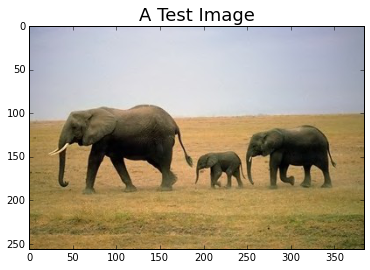

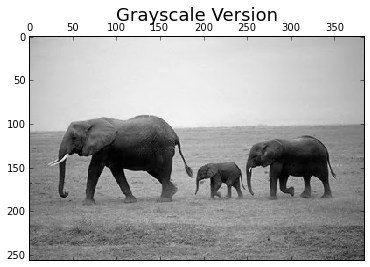

In [2]:
import scipy.ndimage as img      # An image processing library

## Load the test image
TestImage = img.imread("elephants.jpg")
plt.imshow(TestImage);
plt.title("A Test Image",fontsize=18);

## Converting the image to grayscale, floating point, and normalized
X = np.array(TestImage,dtype=float)
X = X[:,:,0]/3 + X[:,:,1]/3 + X[:,:,2]/3
X = X / la.norm(X)

plt.matshow(X);
plt.gray();
plt.title("Grayscale Version",fontsize=18);

Here we have a nice test image. Is this image sparse? Is it compressible? It is not immediately clear from looking at it in the image domain. However, intuitively, we can see that there should be a concise description of this image. Very broadly, the image consists of just 3 different textures, the sky, the ground, and the elephants. Within these textures the textures are more or less consistent. So, the information cotent of the image, beyond describing these particular textures, is the description of the boundaries, or edges, between the textures.

Note that, above, we have converted the image to grayscale. This makes the example simpler. Otherwise, we would need to consider three different color channels in all of our operations.

One of the commonly used transforms in image compression (ala the JPEG compression standard) is the *Discrete Cosine Transform*. One can think of the DCT as a real version of the Fourier Transform. The DCT comes in a few different flavors, but "the" DCT is known as the Type 2 DCT, or DCT-II. The DCT-II of a signal is given as

$$X_j = \sum_{i=0}^{N-1} x_i \cos \left[\frac{\pi}{N}(i+0.5) j\right],$$

where the coefficients $X_j$ refer to our DCT-II coefficients. Like the Fourier transform, the DCT-II builds up an exact representation of $x$ via waveforms of varying frequency, here, cosines. Also like the Fourier transform, we can see that the DCT-II is a *linear* transform, that is, all coefficients are defined according to a sum over the time-domain coefficients and vice-versa. Finally, the DCT-II is also an *orthonormal* transform, so its transpose serves as its own inverse,

$$\Psi_{\text DCT}^T \Psi_{\text DCT} = I$$.

Lets take a look at the DCT-II coefficients of this test image. This requires us to apply the DCT-II in both the horizontal and vertical directions (the same procedure which is used to compute the 2D FFT).

In [3]:
Xdct = fftpk.dct(fftpk.dct(X.T).T)  # Apply to both directions

Out of curiosity, what do these coefficients look like?

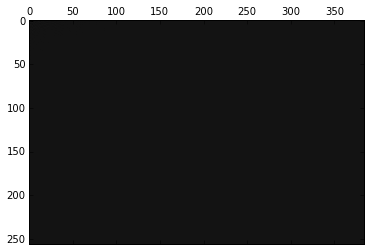

In [4]:
plt.matshow(Xdct);

The scale of the values of the DCT-II is very widely varying, so to *see* the coefficients visually, we usually plot the magnitudes on a log scale.

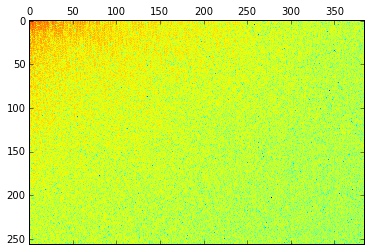

In [5]:
plt.matshow(np.log10(np.abs(Xdct)));
plt.jet()

Cursorially, we see that the largest magnitudes are bunching towards the top-left corner of the 2D set of DCT-II coefficients. This region corresponds to the lowest-frequency terms in our DCT-II transform space. The implication is that the low-pass portion of the DCT-II space contains the majority of the information about the image.

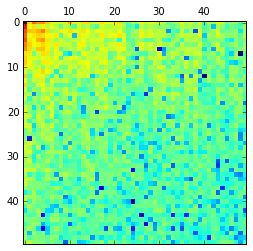

In [6]:
plt.matshow(np.log10(np.abs(Xdct[0:50,0:50])));
plt.jet()

Even zooming further onto the low-pass coefficeints, we see that the information is further clustered into the lower $10\times 7$ set of frequencies. What happens if we retain these but none of the others?

In [7]:
Xdct_lopass = np.zeros(np.shape(Xdct))
Xdct_lopass[0:6,0:9] = Xdct[0:6,0:9]
Xrec =  fftpk.idct(fftpk.idct(Xdct_lopass.T,norm='ortho').T,norm='ortho')

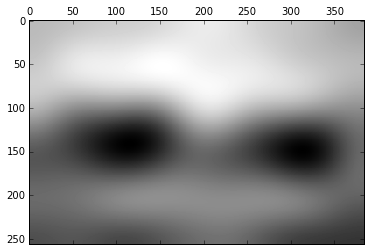

In [8]:
plt.matshow(Xrec)
plt.gray()

So, we can see that these coefficeints contain information about the darker regions (the elephants), the ground, and the sky. However, this is not enough information to be useful. What about if we keep the $50\times 50$ region?

/Users/eric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


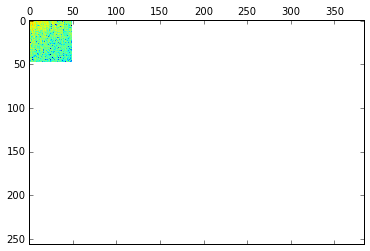

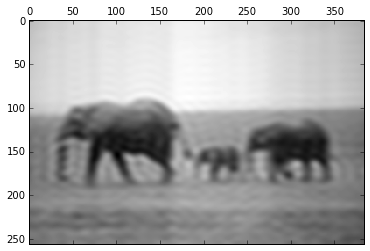

In [9]:
Xdct_lopass = np.zeros(np.shape(Xdct),dtype=float)
Xdct_lopass[0:49,0:49] = Xdct[0:49,0:49]
# Xdct_lopass = np.array(Xdct)
plt.matshow(np.log10(np.abs(Xdct_lopass)))
plt.jet()

Xrec =  fftpk.idct(fftpk.idct(Xdct_lopass.T,norm='ortho').T,norm='ortho')
plt.matshow(Xrec)
plt.gray();

Now, we have a recognizable image. How many coefficeints did we retain, here? 

In [10]:
print "%f%% Coefficients Retained" % (100*(50.0*50.0)/np.size(X))

2.543132% Coefficients Retained


So we can see that even with a very small percentage of the coefficients, we still retain much of the information. The image is still recognizable as three elephants in a line on a field with a horizon in the background. Adding more frequency components will allow us to get closer and closer to the original image. 

Just how compressible is this image? We can look at the weight decay.

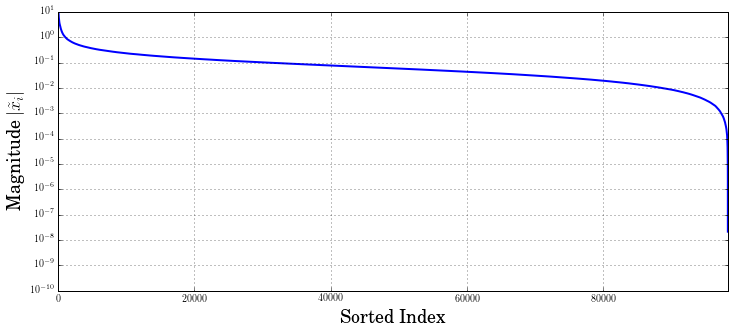

In [11]:
ShowDecay(Xdct)

Does it fit a power-law?

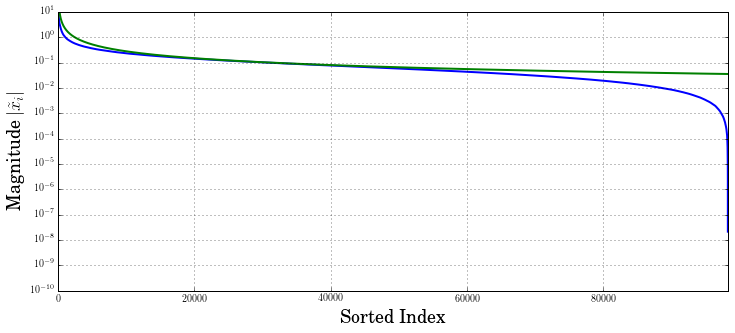

In [12]:
ShowDecay(Xdct,scalemode='log');
## Can we find the proper set of parameters 
## which bound the decay?
C = 1100       
a = 0.9
s = np.arange(1,np.size(X))
plt.plot(s,C*np.power(s,-a),linewidth=2);
## Uncomment these lines to see the decay comparison
## in the linear domain.
# plt.xscale('linear')
# plt.yscale('linear')

And, in fact, we see that it does indeed obey a power-law decay quite well, hence the use of DCT-II for $K$-sparse representation of images.

Yet another tool which is used for image compression are *wavelets* (ala JPEG2000). The study of wavelets is a huge topic and is somewhat beyond the scope of this notebook. The best way to think about wavelets is that this representation exists half way between the time- and frequency-basis. Recall that when we use a harmonic analysis such as the Fourier transform or the DCT, we seek to represent our signal as a superposition of many periodic (*infinitely long*) sinusoids. These sinusoids are completely non-local. As such, a single sinusoid will tell us some information about every time sample, and vice-versa. 

In the case of wavelets, (né «onde-lettes»), a signal is represented by *localized* sinusoids. These localized shapes can exist at any location **and** at any scale. Because of this, wavlet representations of a signal are naturally *multi-scale*, capturing the structure of the signal across many different levels of detail. 

One can represent a signal *exactly* with a wavelet representation, just as is the case with the FFT and DCT-II, and this is accomplished by clever self-referential properties of the wavelet construction. 

In [26]:
Levels = 5      # Number of levels of wavelet decomposition
W = pw.wavedec2(X,'db1',level=Levels,mode='sym');

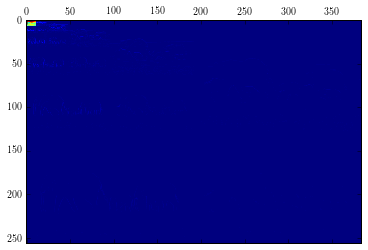

In [27]:
ShowWaveletCoeffs(W)

In [28]:
def ShowWaveletDecay(w):
    x = np.reshape(w[0],(np.size(w[0]),1))

    for l in range(1,np.size(w)):
        h = np.reshape(w[l][0],(np.size(w[l][0]),1))
        v = np.reshape(w[l][1],(np.size(w[l][1]),1))
        d = np.reshape(w[l][2],(np.size(w[l][2]),1))
        x = np.concatenate((x,h,v,d),axis=0)

    ShowDecay(x)

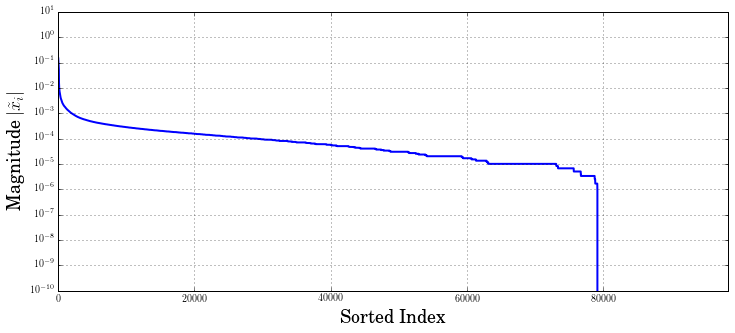

In [29]:
ShowWaveletDecay(W)

In [45]:
Q = pw.dwt2(X,'db4',mode='sym')

In [46]:
np.shape(Q)
np.shape(Q[0])

(131, 195)

In [47]:
?pw.threshold

In [48]:
A = pw.threshold(W,2)

TypeError: bad operand type for abs(): 'tuple'

In [49]:
?pw.threshold